In [1]:
import ast
import os
import re
import time
from glob import glob
from typing import Any, Dict, Literal, Optional, Union

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import pywt
import timm
import torch
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from scipy.ndimage import binary_dilation, label
from scipy.spatial import cKDTree
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm.notebook import tqdm
from zoobot.pytorch.training.representations import ZoobotEncoder

# Functions

In [2]:
def read_h5(file_path):
    """
    Reads cutout data from HDF5 file
    :param file_path: path to HDF5 file
    :return: cutout data
    """
    with h5py.File(file_path, "r") as f:
        # Create empty dictionaries to store data for each group
        cutout_data = {}

        # Loop through datasets
        for dataset_name in f:
            if dataset_name == "images":
                data = np.nan_to_num(np.array(f[dataset_name]), nan=0.0)
            else:
                data = np.array(f[dataset_name])
            cutout_data[dataset_name] = data
    return cutout_data


def extract_and_save_objects(
    catalog_path, output_dir, base_path="/projects/unions/ssl/data/raw/tiles/dwarforge"
):
    """
    Extract objects from HDF5 files based on a catalog and save them to new HDF5 files in chunks of 5000 objects.

    Parameters:
    -----------
    catalog_path : str
        Path to the catalog file containing 'tile', 'unique_id', 'Z', and 'LOGM_CIGALE' columns.
    output_dir : str
        Directory where output HDF5 files will be saved.
    base_path : str
        Base path to the directory containing the tile directories.

    Returns:
    --------
    tuple
        (objects_processed, objects_not_found, files_created)
    """
    # 1. Load and prepare the catalog
    print("Loading catalog...")
    catalog = pd.read_csv(catalog_path, low_memory=False)

    # Check if required columns exist
    required_cols = ["tile", "unique_id", "Z", "LOGM_CIGALE"]
    for col in required_cols:
        if col not in catalog.columns:
            raise ValueError(f"Required column '{col}' not found in catalog")

    # 2. Group objects by tile
    print("Grouping objects by tile...")
    grouped_catalog = catalog.groupby("tile")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize data accumulation
    accumulated_data = {}
    accumulated_count = 0
    datasets_to_extract = None
    bands_data = None
    tile_data = None

    # Counters for statistics
    total_objects = len(catalog)
    objects_processed = 0
    objects_not_found = 0
    files_created = 0

    print(
        f"Processing {len(grouped_catalog)} unique tiles with {total_objects} total objects..."
    )

    # 3. Process each tile
    for tile, tile_objects in tqdm(grouped_catalog):
        # Get the tile format
        tile_formatted = str(tile)
        # Construct file path
        tile_path = f"{base_path}/{tile_formatted}/gri/{tile_formatted}_matched_cutouts_full_res_final.h5"

        try:
            with h5py.File(tile_path, "r") as src_file:
                # 4. Create object index mapping
                unique_ids = src_file["unique_id"][:]
                id_to_index = {uid: idx for idx, uid in enumerate(unique_ids)}

                # Store bands data (only need to do this once)
                if bands_data is None:
                    bands_data = src_file["band_names"][:]
                    tile_data = src_file["tile"][:]

                # Get list of datasets to copy (all except 'bands')
                if datasets_to_extract is None:
                    datasets_to_extract = [
                        key
                        for key in src_file.keys()
                        if key not in ["band_names", "tile"]
                    ]

                    # Initialize data accumulation
                    for dataset_name in datasets_to_extract:
                        accumulated_data[dataset_name] = []

                    # Add our new datasets
                    accumulated_data["Z"] = []
                    accumulated_data["LOGM_CIGALE"] = []

                # 5. Select objects for extraction
                tile_objects_array = tile_objects["unique_id"].values
                valid_indices = []
                valid_catalog_indices = []

                for cat_idx, uid in enumerate(tile_objects_array):
                    if uid in id_to_index:
                        valid_indices.append(id_to_index[uid])
                        valid_catalog_indices.append(cat_idx)
                    else:
                        objects_not_found += 1

                n_valid = len(valid_indices)
                if n_valid == 0:
                    print(f"No valid objects found in tile {tile_formatted}")
                    continue

                # 6. Extract data for each dataset
                for dataset_name in datasets_to_extract:
                    extracted_data = src_file[dataset_name][:][valid_indices]
                    accumulated_data[dataset_name].append(extracted_data)

                # Add Z and LOGM_CIGALE from catalog
                z_values = tile_objects.iloc[valid_catalog_indices]["Z"].values
                logm_values = tile_objects.iloc[valid_catalog_indices][
                    "LOGM_CIGALE"
                ].values

                accumulated_data["Z"].append(z_values)
                accumulated_data["LOGM_CIGALE"].append(logm_values)

                # Update object counts
                accumulated_count += n_valid
                objects_processed += n_valid

                # Check if we have enough objects to save a chunk
                while accumulated_count >= 5000:
                    # Save a chunk of exactly 5000 objects
                    accumulated_count = save_chunk(
                        accumulated_data,
                        bands_data,
                        tile_data,
                        output_dir,
                        files_created,
                        accumulated_count,
                    )
                    files_created += 1

        except FileNotFoundError:
            print(f"Warning: File not found for tile {tile_formatted} at {tile_path}")
            objects_not_found += len(tile_objects)

    # Save any remaining objects
    if accumulated_count > 0:
        save_chunk(
            accumulated_data,
            bands_data,
            tile_data,
            output_dir,
            files_created,
            accumulated_count,
            is_final=True,
        )
        files_created += 1

    print(f"Processing complete:")
    print(f"  Total objects processed: {objects_processed}/{total_objects}")
    print(f"  Objects not found: {objects_not_found}")
    print(f"  Output files created: {files_created}")

    return objects_processed, objects_not_found, files_created


def save_chunk(
    accumulated_data,
    bands_data,
    tile_data,
    output_dir,
    chunk_index,
    accumulated_count,
    is_final=False,
):
    """
    Save a chunk of exactly 5000 objects (or fewer if it's the last chunk) to an HDF5 file.

    Parameters:
    -----------
    accumulated_data : dict
        Dictionary containing lists of arrays for each dataset
    bands_data : ndarray
        The 'bands' dataset to save with each chunk
    tile_data : ndarray
        The 'tile' dataset to save with each chunk
    output_dir : str
        Directory to save the output file
    chunk_index : int
        Index for the chunk file name
    accumulated_count : int
        Total number of objects accumulated
    is_final : bool, optional
        Whether this is the final chunk (may be less than 5000 objects)

    Returns:
    --------
    int
        Number of objects remaining after saving the chunk
    """
    output_path = os.path.join(output_dir, f"chunk_{chunk_index:04d}.h5")

    # Determine how many objects to save
    objects_to_save = 5000 if not is_final else accumulated_count
    objects_to_save = min(objects_to_save, accumulated_count)

    print(f"Saving chunk {chunk_index} with {objects_to_save} objects to {output_path}")

    # Create a dictionary to store concatenated data
    concatenated_data = {}

    # Concatenate arrays for each dataset
    for dataset_name, arrays in accumulated_data.items():
        if arrays:  # Check if there are any arrays to concatenate
            concatenated_data[dataset_name] = np.concatenate(arrays)

    # Open output file and save data
    with h5py.File(output_path, "w") as out_file:
        # Save each dataset (first objects_to_save objects)
        for dataset_name, data in concatenated_data.items():
            chunk_data = data[:objects_to_save]
            out_file.create_dataset(dataset_name, data=chunk_data)

        # Save the bands dataset
        out_file.create_dataset("band_names", data=bands_data)
        out_file.create_dataset("tile", data=tile_data)

    # Update the accumulated_data to keep remaining objects
    for dataset_name, data in concatenated_data.items():
        if len(data) > objects_to_save:
            accumulated_data[dataset_name] = [data[objects_to_save:]]
        else:
            accumulated_data[dataset_name] = []

    # Return the number of objects remaining
    return accumulated_count - objects_to_save

# RGB Functions

In [3]:
def preprocess_cutout(
    cutout: np.ndarray, mode: str = "vis", replace_anomaly: bool = True
) -> np.ndarray:
    """Create an RGB image from the cutout data and save or plot it.

    Args:
        cutout (numpy.ndarray): cutout data with shape (channels, height, width)
        mode (str, optional): mode of operation. Defaults to 'training'. Valid options are 'training' or 'vis'. Fills missing channels for visualization.

    Returns:
        numpy.ndarray: preprocessed image cutout

    """
    # map out bands to RGB
    cutout_red = cutout[2]  # i-band
    cutout_green = cutout[1]  # r-band
    cutout_blue = cutout[0]  # g-band

    # adjust zero-point for the g-band
    if np.count_nonzero(cutout_blue) > 0:
        cutout_blue = adjust_flux_with_zp(cutout_blue, 27.0, 30.0)

    if replace_anomaly:
        # replace anomalies
        cutout_red = detect_anomaly(cutout_red)
        cutout_green = detect_anomaly(cutout_green)
        cutout_blue = detect_anomaly(cutout_blue)

    # synthesize missing channel from the existing ones
    # longest valid wavelength is mapped to red, middle to green, shortest to blue
    if mode == "vis":
        if np.count_nonzero(cutout_red > 1e-10) == 0:
            cutout_red = cutout_green
            cutout_green = (cutout_green + cutout_blue) / 2
        elif np.count_nonzero(cutout_green > 1e-10) == 0:
            cutout_green = (cutout_red + cutout_blue) / 2
        elif np.count_nonzero(cutout_blue > 1e-10) == 0:
            cutout_blue = cutout_red
            cutout_red = (cutout_red + cutout_green) / 2

    # stack the channels in the order red, green, blue
    cutout_prep = np.stack([cutout_red, cutout_green, cutout_blue], axis=-1)

    return cutout_prep


def generate_rgb(
    cutout: np.ndarray,
    scaling_type: Literal["asinh", "linear"] = "asinh",
    stretch: float = 125,
    Q: float = 7.0,
    gamma: float = 0.25,
) -> np.ndarray:
    """Create an RGB image from three bands of data preserving relative intensities.

    Processes multi-band astronomical data into a properly scaled RGB image
    suitable for visualization, handling high dynamic range and empty channels.

    Args:
        cutout: 3D array of shape (height, width, 3) with band data
        scaling_type: Type of scaling to apply ("asinh" or "linear")
        stretch: Scaling factor controlling overall brightness
        Q: Softening parameter for asinh scaling (higher = more linear)
        gamma: Gamma correction factor (lower = enhances faint features)

    Returns:
        Normalized RGB image with values in range [0, 1]

    Notes:
        For astronomical data with high dynamic range, "asinh" scaling is
        typically preferred as it preserves both bright and faint details.
    """
    frac = 0.1
    with np.errstate(divide="ignore", invalid="ignore"):
        red = cutout[:, :, 0]
        green = cutout[:, :, 1]
        blue = cutout[:, :, 2]

        # Check for zero channels
        red_is_zero = np.all(red == 0)
        green_is_zero = np.all(green == 0)
        blue_is_zero = np.all(blue == 0)

        # Compute average intensity before scaling choice (avoiding zero channels)
        nonzero_channels = []
        if not red_is_zero:
            nonzero_channels.append(red)
        if not green_is_zero:
            nonzero_channels.append(green)
        if not blue_is_zero:
            nonzero_channels.append(blue)

        if nonzero_channels:
            i_mean = sum(nonzero_channels) / len(nonzero_channels)
        else:
            i_mean = np.zeros_like(red)  # All channels are zero

        if scaling_type == "asinh":
            # Apply asinh scaling
            if not red_is_zero:
                red = red * np.arcsinh(Q * i_mean / stretch) / (Q * i_mean)
            if not green_is_zero:
                green = green * np.arcsinh(Q * i_mean / stretch) / (Q * i_mean)
            if not blue_is_zero:
                blue = blue * np.arcsinh(Q * i_mean / stretch) / (Q * i_mean)
        elif scaling_type == "asinh_frac":
            # Apply asinh scaling
            if not red_is_zero:
                red = (
                    red
                    * np.arcsinh(Q * i_mean / stretch)
                    * frac
                    / (np.arcsinh(frac * Q) * i_mean)
                )
            if not green_is_zero:
                green = (
                    green
                    * np.arcsinh(Q * i_mean / stretch)
                    * frac
                    / (np.arcsinh(frac * Q) * i_mean)
                )
            if not blue_is_zero:
                blue = (
                    blue
                    * np.arcsinh(Q * i_mean / stretch)
                    * frac
                    / (np.arcsinh(frac * Q) * i_mean)
                )
        elif scaling_type == "linear":
            # Apply linear scaling
            if not red_is_zero:
                red = red * stretch
            if not green_is_zero:
                green = green * stretch
            if not blue_is_zero:
                blue = blue * stretch
        else:
            raise ValueError(f"Unknown scaling type: {scaling_type}")

        # Apply gamma correction while preserving sign
        if gamma is not None:
            if not red_is_zero:
                red_mask = abs(red) <= 1e-9
                red = np.sign(red) * (abs(red) ** gamma)
                red[red_mask] = 0

            if not green_is_zero:
                green_mask = abs(green) <= 1e-9
                green = np.sign(green) * (abs(green) ** gamma)
                green[green_mask] = 0

            if not blue_is_zero:
                blue_mask = abs(blue) <= 1e-9
                blue = np.sign(blue) * (abs(blue) ** gamma)
                blue[blue_mask] = 0
        # Stack the channels after scaling and gamma correction
        result = np.stack([red, green, blue], axis=-1).astype(np.float32)

    # back to original axis ordering
    result = np.moveaxis(result, -1, 0)

    return result


def adjust_flux_with_zp(
    flux: np.ndarray, current_zp: Union[float, int], standard_zp: Union[float, int]
) -> np.ndarray:
    """
    Adjust flux values to a standard zero-point.

    Args:
        flux (numpy.ndarray): Flux values to adjust.
        current_zp (float/int): Current zero-point of the flux values.
        standard_zp (float/int): Standard zero-point to adjust to.

    Returns:
        numpy.ndarray: Adjusted flux values.
    """
    adjusted_flux = flux * 10 ** (-0.4 * (current_zp - standard_zp))
    return adjusted_flux


def detect_anomaly(
    image: np.ndarray,
    zero_threshold: float = 0.05,
    min_size: int = 50,
    replace_anomaly: bool = True,
    dilate_mask: bool = True,
    dilation_iters: int = 1,
) -> np.ndarray:
    """
    Detect and replace anomalies in an image using wavelet decomposition.

    This function analyzes an astronomical image to identify anomalous regions
    by performing wavelet decomposition and identifying regions with minimal
    fluctuations below a threshold. It can optionally replace detected anomalous
    pixels with zeros.

    Args:
        image: Input astronomical image to process
        zero_threshold: Fluctuation threshold below which an anomaly is detected
        min_size: Minimum connected pixel count to be considered an anomaly
        replace_anomaly: Whether to set anomalous pixels to zero
        dilate_mask: Whether to expand the detected anomaly mask
        dilation_iters: Number of dilation iterations if dilate_mask is True

    Returns:
        Processed image with anomalies optionally replaced

    Notes:
        This function uses Haar wavelet decomposition to identify regions with
        suspiciously low variation, which often indicate detector artifacts or
        other non-astronomical features in the image.
    """
    # replace nan values with zeros
    image[np.isnan(image)] = 0.0

    # Perform a 2D Discrete Wavelet Transform using Haar wavelets
    coeffs = pywt.dwt2(image, "haar")
    cA, (cH, cV, cD) = coeffs  # Decomposition into approximation and details

    # Create binary masks where wavelet coefficients are below the threshold
    mask_horizontal = np.abs(cH) <= zero_threshold
    mask_vertical = np.abs(cV) <= zero_threshold
    mask_diagonal = np.abs(cD) <= zero_threshold

    masks = [mask_diagonal, mask_horizontal, mask_vertical]

    # Create a global mask to accumulate all anomalies
    global_mask = np.zeros_like(image, dtype=bool)
    # Create masks for each component
    component_masks = np.zeros((3, cA.shape[0], cA.shape[1]), dtype=bool)
    anomalies = np.zeros(3, dtype=bool)
    for i, mask in enumerate(masks):
        # Apply connected-component labeling to find connected regions in the mask
        labeled_array, num_features = label(mask)  # type: ignore

        # Calculate the sizes of all components
        component_sizes = np.bincount(labeled_array.ravel())

        # Check if any component is larger than the minimum size
        anomaly_detected = np.any(component_sizes[1:] >= min_size)
        anomalies[i] = anomaly_detected

        if not anomaly_detected:
            continue

        # Prepare to accumulate a total mask
        total_feature_mask = np.zeros_like(image, dtype=bool)

        # Loop through all labels to find significant components
        for component_label in range(
            1, num_features + 1
        ):  # Start from 1 to skip background
            if component_sizes[component_label] >= min_size:
                # Create a binary mask for this component
                component_mask = labeled_array == component_label
                # add component mask to component masks
                component_masks[i] |= component_mask
                # Upscale the mask to match the original image dimensions
                upscaled_mask = np.kron(component_mask, np.ones((2, 2), dtype=bool))
                # Accumulate the upscaled feature mask
                total_feature_mask |= upscaled_mask

        # Accumulate global mask
        global_mask |= total_feature_mask
        # Dilate the masks to catch some odd pixels on the outskirts of the anomaly
        if dilate_mask:
            global_mask = binary_dilation(global_mask, iterations=dilation_iters)
            for j, comp_mask in enumerate(component_masks):
                component_masks[j] = binary_dilation(
                    comp_mask, iterations=dilation_iters
                )
    # Replace the anomaly with zeros
    if replace_anomaly:
        image[global_mask] = 0.0

    return image


def preprocess_h5_images(
    h5_file_path,
    output_dir=None,
    replace_anomaly=True,
    scaling_type="asinh",
    mode="vis",
    stretch=125,
    Q=7.0,
    gamma=0.25,
    use_compression=False,
):
    """
    Read an H5 file containing image cutouts, preprocess them, and save to a new H5 file.

    Parameters:
    -----------
    h5_file_path : str
        Path to the input H5 file containing image cutouts.
    output_dir : str, optional
        Directory where the processed H5 file will be saved. If None, uses same directory as input.
    replace_anomaly : bool, optional
        Whether to replace anomalies in the images. Default is True.
    scaling_type : str, optional
        Type of scaling to apply ("asinh" or "linear"). Default is "asinh".
    stretch : float, optional
        Scaling factor controlling overall brightness. Default is 125.
    Q : float, optional
        Softening parameter for asinh scaling. Default is 7.0.
    gamma : float, optional
        Gamma correction factor. Default is 0.25.
    use_compression : bool, optional
        Whether to compress the output datasets. Default is False for faster read
        times during deep learning training.

    Returns:
    --------
    str
        Path to the output H5 file.
    """
    # Set output directory and filename
    if output_dir is None:
        output_dir = os.path.dirname(h5_file_path)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Generate output filename
    base_name = os.path.basename(h5_file_path)
    output_filename = os.path.splitext(base_name)[0] + "_prep.h5"
    output_path = os.path.join(output_dir, output_filename)

    print(f"Processing {h5_file_path} -> {output_path}")

    # Open input file for reading
    with h5py.File(h5_file_path, "r") as src_file:
        # Get image data
        images = src_file["images"][:]
        num_objects = images.shape[0]

        print(f"Found {num_objects} objects with image shape {images.shape[1:]}")

        # Create output file
        with h5py.File(output_path, "w") as out_file:
            # Process images
            processed_images = np.zeros(
                (num_objects, 3, images.shape[2], images.shape[3]), dtype=np.float32
            )

            print("Processing images...")
            for i in tqdm(range(num_objects)):
                # Get the current cutout (with shape [channels, height, width])
                cutout = images[i]

                # Apply preprocessing to convert to RGB format
                preprocessed = preprocess_cutout(
                    cutout, mode=mode, replace_anomaly=replace_anomaly
                )

                # Apply RGB scaling and normalization
                rgb_image = generate_rgb(
                    preprocessed,
                    scaling_type=scaling_type,
                    stretch=stretch,
                    Q=Q,
                    gamma=gamma,
                )

                # Store processed image
                processed_images[i] = rgb_image

            # Save processed images to output file
            if use_compression:
                out_file.create_dataset(
                    "images",
                    data=processed_images,
                    compression="gzip",
                    compression_opts=6,
                )
            else:
                # No compression for faster read times during training
                out_file.create_dataset("images", data=processed_images)

            # Copy all other datasets from source file
            print("Copying metadata and other datasets...")
            for key in src_file.keys():
                if key != "images" and key not in out_file:
                    src_file.copy(key, out_file)

            # Add processing parameters as attributes
            out_file.attrs["preprocessing_replace_anomaly"] = replace_anomaly
            out_file.attrs["rgb_scaling_type"] = scaling_type
            out_file.attrs["rgb_stretch"] = stretch
            out_file.attrs["rgb_Q"] = Q
            out_file.attrs["rgb_gamma"] = gamma
            out_file.attrs["compression_used"] = use_compression

    print(f"Processing complete. Output saved to {output_path}")
    return output_path

# Paths

In [4]:
data_dir = "/arc/projects/unions/ssl/data/raw/tiles/dwarforge"
table_dir = "/arc/home/heestersnick/dwarforge/tables"
output_dir = "/arc/home/heestersnick/dwarforge/desi"
desi_unions_path = os.path.join(table_dir, "all_desi_unions_matched.csv")
desi_unions_matched = pd.read_csv(desi_unions_path, low_memory=False)

# Collect matched object data & save to new file(s)

In [ ]:
extract_and_save_objects(
    catalog_path=desi_unions_path, output_dir=output_dir, base_path=data_dir
)

# Make data RGB-ready

In [ ]:
h5_file_path = os.path.join(output_dir, "chunk_0004.h5")

In [ ]:
_ = preprocess_h5_images(
    h5_file_path,
    output_dir=output_dir,
    replace_anomaly=True,
    scaling_type="asinh",
    stretch=125,
    Q=7.0,
    gamma=0.25,
    use_compression=False,
)

# Check RGB-ready file

In [ ]:
test_orig = read_h5("/arc/home/heestersnick/dwarforge/desi/chunk_0004.h5")

In [ ]:
test["images"].shape

In [ ]:
idx = 3083

z = test["Z"][idx]
ra, dec = test["ra"][idx], test["dec"][idx]
zoobot_pred = test["zoobot_pred"][idx]

cutout = test["images"][idx]
cutout = np.moveaxis(cutout, 0, -1)
cutout = np.clip(cutout, 0, 1)

plt.figure(figsize=(6, 6), frameon=False, clear=True)
plt.imshow(cutout, origin="lower")
plt.show()

print(f"Object is at ({ra:.4f}, {dec:.4f}) at a redshift of {z:.4f}")
print(f"Zoobot pred: {zoobot_pred:.3f}")

# Get Zoobot latent vectors

In [5]:
def load_zoobot_model(name="hf_hub:mwalmsley/zoobot-encoder-convnext_nano"):
    model = ZoobotEncoder.load_from_name(name)
    model.freeze()
    model.eval()
    model = model.to(DEVICE)
    print(
        f'Model is on device: {next(model.parameters()).device}.\nModel is in eval mode: {all(not p.requires_grad for p in model.parameters())}.\nModel architecture is: {model.encoder.default_cfg["architecture"]}'
    )
    return model


def run_inference(model, images_np, batch_size=256):
    """
    Args:
        images_np: numpy array of shape (N, 3, H, W)

    Returns:
        latent representations: numpy array of shape (N,640)
    """
    # 1. Verify input normalization
    assert images_np.dtype == np.float32, "Input must be float32"

    # 2. Convert to tensor
    images_tensor = torch.tensor(images_np, dtype=torch.float32)

    # 3. Create DataLoader
    dataset = TensorDataset(images_tensor)
    dataloader = DataLoader(
        dataset, batch_size=batch_size, num_workers=0, pin_memory=True
    )

    # 4. Run inference
    latent_representations = []
    model.eval()  # Redundant with freeze() but safe

    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = batch[0].to(model.device)
            latent = model(inputs)
            latent_representations.append(latent.cpu().numpy())

    return np.concatenate(latent_representations)


def process_objects_with_model(
    catalog_path: str,
    output_path: str,
    model: Any,  # Ideally replace Any with torch.nn.Module or specific model type
    base_path: str = "/projects/unions/ssl/data/raw/tiles/dwarforge",
    accumulation_size: int = 5000,
    preprocessing_params: Optional[Dict[str, Any]] = None,
) -> Dict[str, int]:
    """
    Process objects from a catalog with a machine learning model and save results.

    Uses efficient HDF5 slicing for image loading and ensures metadata alignment
    by sorting both images and corresponding metadata based on HDF5 index order.

    Parameters:
    -----------
    catalog_path : str
        Path to the catalog CSV file. Requires columns:
        'tile', 'unique_id', 'ra', 'dec', 'Z', 'LOGM_CIGALE'.
    output_path : str
        Path to the output H5 file where results will be saved.
    model : object
        The machine learning model for latent vector extraction.
    base_path : str, optional
        Base path to the directory containing tile subdirectories.
    accumulation_size : int, optional
        Number of preprocessed images to accumulate before running inference. Default is 5000.
    preprocessing_params : dict, optional
        Parameters for image preprocessing. Defaults will be used if None.

    Returns:
    --------
    dict
        Statistics about the processing (objects processed, not found, etc.)
    """
    # 1. Load and prepare the catalog
    print("Loading catalog...")
    catalog = pd.read_csv(catalog_path, low_memory=False)

    # Check if required columns exist
    required_cols = ["tile", "unique_id", "ra", "dec", "z", "zerr"]
    for col in required_cols:
        if col not in catalog.columns:
            raise ValueError(f"Required column '{col}' not found in catalog")

    # Ensure unique_id is integer type if needed for matching H5 IDs
    # catalog['unique_id'] = catalog['unique_id'].astype(int) # Uncomment if necessary

    # Create output directory if needed
    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    # Set default preprocessing parameters if not provided
    if preprocessing_params is None:
        preprocessing_params = {
            "replace_anomaly": True,
            "scaling_type": "asinh",
            "mode": "vis",
            "stretch": 125,
            "Q": 7.0,
            "gamma": 0.25,
        }

    # 2. Group objects by tile
    print("Grouping objects by tile...")
    grouped_catalog = catalog.groupby("tile")

    # Initialize data collection
    latent_vectors: List[np.ndarray] = []
    metadata = {
        "unique_id": [],
        "ra": [],
        "dec": [],
        "tile": [],
        "z": [],
        "zerr": [],
    }  # Lists to hold batches of metadata arrays

    # Counters for statistics
    total_objects = len(catalog)
    objects_processed = 0
    objects_not_found = 0

    # Accumulation buffers
    accumulated_images: List[np.ndarray] = []
    accumulated_metadata = {
        key: [] for key in metadata.keys()
    }  # Lists to hold batches before inference

    print(
        f"Processing {len(grouped_catalog)} unique tiles with {total_objects} total objects..."
    )

    # 3. Process each tile
    for tile, tile_objects in tqdm(grouped_catalog, desc="Processing tiles"):
        tile_formatted = str(tile)
        # Construct file path (adjust if structure differs)
        tile_path = f"{base_path}/{tile_formatted}/gri/{tile_formatted}_matched_cutouts_full_res_final.h5"

        try:
            with h5py.File(tile_path, "r") as src_file:
                # --- Efficient Object Selection & Loading ---

                # 1. Get target IDs required for this tile from the catalog
                target_ids = tile_objects["unique_id"].values
                num_targets_in_catalog = len(target_ids)

                # 2. Load unique IDs available in the H5 file
                if "unique_id" not in src_file:
                    print(
                        f"Warning: 'unique_id' dataset not found in tile {tile_formatted}. Skipping."
                    )
                    objects_not_found += num_targets_in_catalog
                    continue
                h5_unique_ids = src_file["unique_id"][:]
                # Ensure h5_unique_ids is 1D array
                if h5_unique_ids.ndim == 0:
                    h5_unique_ids = np.array([h5_unique_ids])
                if h5_unique_ids.ndim > 1:
                    h5_unique_ids = h5_unique_ids.flatten()  # Adjust if needed

                # 3. Find matches: Map H5 IDs to their indices
                h5_id_to_index = {uid: idx for idx, uid in enumerate(h5_unique_ids)}

                # 4. Identify indices in H5 and corresponding catalog rows
                valid_indices: List[int] = []  # Indices within H5 file
                catalog_indices_to_keep: List[int] = []  # Indices within tile_objects

                for cat_idx, target_id in enumerate(target_ids):
                    h5_idx = h5_id_to_index.get(
                        target_id
                    )  # More efficient than 'in' + lookup
                    if h5_idx is not None:
                        valid_indices.append(h5_idx)
                        catalog_indices_to_keep.append(cat_idx)

                n_valid = len(valid_indices)
                num_not_found_in_tile = num_targets_in_catalog - n_valid
                objects_not_found += num_not_found_in_tile

                if n_valid == 0:
                    if num_targets_in_catalog > 0:
                        print(
                            f"Warning: No matching objects found in file {tile_path} for {num_targets_in_catalog} catalog entries."
                        )
                    continue  # Skip to the next tile

                # 5. Get initial metadata rows in the original discovery order
                valid_catalog_objects = tile_objects.iloc[catalog_indices_to_keep]

                # --- Sorting for Efficient HDF5 Read & Metadata Alignment ---
                # 6. Get the order needed to sort the H5 indices
                valid_indices_arr = np.array(valid_indices)
                sort_order = np.argsort(valid_indices_arr)

                # 7. Apply sort order to get sorted H5 indices
                sorted_h5_indices = valid_indices_arr[sort_order]

                # 8. Apply the SAME sort order to the metadata DataFrame
                valid_catalog_objects_sorted = valid_catalog_objects.iloc[sort_order]
                # --- End Sorting ---

                # 9. Extract only the required images using sorted H5 indices
                if "images" not in src_file:
                    print(
                        f"Warning: 'images' dataset not found in tile {tile_formatted}. Skipping {n_valid} found objects."
                    )
                    objects_not_found += n_valid  # Count these as not found now
                    continue
                images = src_file["images"][sorted_h5_indices]
                # 'images' now corresponds row-by-row to 'valid_catalog_objects_sorted'

                # 10. Preprocess all extracted images for this tile
                # Assuming H, W are last dims in H5, C=3 is output of generate_rgb
                preprocessed_images = np.zeros(
                    (n_valid, 3, images.shape[-2], images.shape[-1]), dtype=np.float32
                )

                for i in range(n_valid):
                    cutout = images[i]  # Already loaded efficiently
                    preprocessed = preprocess_cutout(
                        cutout,
                        mode=preprocessing_params["mode"],
                        replace_anomaly=preprocessing_params["replace_anomaly"],
                    )
                    rgb_image = generate_rgb(
                        preprocessed,
                        scaling_type=preprocessing_params["scaling_type"],
                        stretch=preprocessing_params["stretch"],
                        Q=preprocessing_params["Q"],
                        gamma=preprocessing_params["gamma"],
                    )
                    preprocessed_images[i] = rgb_image

                # Set problematic values to 0
                preprocessed_images_clean = np.nan_to_num(
                    preprocessed_images, nan=0.0, posinf=0.0, neginf=0.0
                )
                
                # 11. Add preprocessed images to accumulation buffer
                accumulated_images.append(preprocessed_images_clean)

                # 12. Add SORTED metadata to accumulation buffer
                accumulated_metadata["unique_id"].append(
                    valid_catalog_objects_sorted["unique_id"].values
                )
                accumulated_metadata["ra"].append(
                    valid_catalog_objects_sorted["ra"].values
                )
                accumulated_metadata["dec"].append(
                    valid_catalog_objects_sorted["dec"].values
                )
                accumulated_metadata["tile"].append(
                    np.full(n_valid, tile)
                )  # Use the actual tile variable
                accumulated_metadata["z"].append(
                    valid_catalog_objects_sorted["z"].values
                )
                accumulated_metadata["zerr"].append(
                    valid_catalog_objects_sorted["zerr"].values
                )

                # 13. Calculate total accumulated images
                total_accumulated = sum(arr.shape[0] for arr in accumulated_images)

                # 14. Run inference when accumulation threshold is met (Original logic)
                # Consider optimizing this part later if it becomes a bottleneck
                while total_accumulated >= accumulation_size:
                    print(
                        f"Running inference on {accumulation_size} accumulated images..."
                    )

                    # Concatenate accumulated images (Potential inefficiency here)
                    all_images = np.concatenate(accumulated_images)
                    inference_images = all_images[:accumulation_size]

                    try:
                        batch_vectors = run_inference(
                            model=model, images_np=np.nan_to_num(inference_images, nan=0.0)
                        )
                        if np.isnan(batch_vectors).any():
                            print(f"!!! WARNING: NaN values detected in latent vectors for a batch.")
                        latent_vectors.append(batch_vectors)  # Add results batch

                        # Process metadata for these images (Potential inefficiency here)
                        remaining_metadata = {key: [] for key in metadata.keys()}
                        processed_count_in_batch = (
                            0  # Track how much metadata corresponds to inference_images
                        )

                        for key in metadata.keys():
                            # Concatenate all buffered metadata for this key
                            all_metadata_values_list = accumulated_metadata[key]
                            if not all_metadata_values_list:
                                continue  # Skip if empty

                            all_values_key = np.concatenate(all_metadata_values_list)

                            # Store metadata for processed images
                            metadata[key].append(all_values_key[:accumulation_size])
                            processed_count_in_batch = len(
                                all_values_key[:accumulation_size]
                            )  # Update count

                            # Keep remaining metadata if any
                            if len(all_values_key) > accumulation_size:
                                remaining_values = all_values_key[accumulation_size:]
                                remaining_metadata[key] = [
                                    remaining_values
                                ]  # Store as list
                            else:
                                remaining_metadata[key] = []  # No remainder

                        # Keep remaining images
                        remaining_images = all_images[accumulation_size:]

                        # Update accumulation buffers
                        accumulated_images = (
                            [remaining_images] if len(remaining_images) > 0 else []
                        )
                        accumulated_metadata = remaining_metadata

                        objects_processed += (
                            processed_count_in_batch  # Use actual count
                        )

                        # Update total accumulated count *after* buffer update
                        total_accumulated = sum(
                            arr.shape[0] for arr in accumulated_images
                        )

                        # Free GPU memory if available
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()

                    except Exception as e:
                        print(
                            f"Error running inference batch: {type(e).__name__} - {e}. Skipping batch."
                        )
                        # Decide how to handle buffers - clear them or try to skip bad data?
                        # Simplest: Clear buffers and hope next tile works.
                        accumulated_images = []
                        accumulated_metadata = {key: [] for key in metadata.keys()}
                        total_accumulated = 0
                        break  # Exit the while loop for this tile after error

        except FileNotFoundError:
            num_expected = len(tile_objects)
            print(
                f"Warning: File not found for tile {tile_formatted} at {tile_path}. Skipping {num_expected} objects."
            )
            objects_not_found += num_expected
        except KeyError as e:
            print(
                f"Error: Dataset missing in H5 file for tile {tile_formatted} (Path: {tile_path}). Missing key: {e}"
            )
            objects_not_found += len(tile_objects)
        except Exception as e:
            print(f"Error processing tile {tile_formatted}: {type(e).__name__} - {e}")
            objects_not_found += len(tile_objects)  # Option: count errors as not found

    # Process any remaining images after the loop (Original logic)
    final_accumulated_count = sum(arr.shape[0] for arr in accumulated_images)
    if final_accumulated_count > 0:
        print(f"Running inference on {final_accumulated_count} remaining images...")
        try:
            all_images = np.concatenate(accumulated_images)
            batch_vectors = run_inference(model=model, images_np=all_images)
            latent_vectors.append(batch_vectors)

            # Process remaining metadata
            for key in metadata.keys():
                if accumulated_metadata[key]:  # Check if list is not empty
                    all_values = np.concatenate(accumulated_metadata[key])
                    metadata[key].append(all_values)
                # Else: no remaining metadata for this key, do nothing

            objects_processed += final_accumulated_count

        except Exception as e:
            print(f"Error processing final batch of images: {type(e).__name__} - {e}")
            # Note: These objects won't be counted in objects_processed if error occurs here

    # Concatenate all collected data (Original logic)
    print("Concatenating final results...")
    all_latent_vectors = (
        np.concatenate(latent_vectors)
        if latent_vectors
        else np.empty((0, 640), dtype=np.float32)
    )  # Specify shape if empty

    all_metadata = {}
    for key in metadata:
        if metadata[key]:  # Check list has batches
            all_metadata[key] = np.concatenate(metadata[key])
        else:  # Create empty array of appropriate type if nothing was processed
            if key == "unique_id":
                dtype = np.int64
            elif key in ["ra", "dec", "z", "zerr"]:
                dtype = np.float64
            elif key == "tile":
                dtype = object  # Or infer from catalog dtype
            else:
                dtype = object
            all_metadata[key] = np.array([], dtype=dtype)

    # Check consistency (optional)
    num_vecs = len(all_latent_vectors)
    num_ids = len(all_metadata.get("unique_id", []))
    if num_vecs != num_ids:
        print(
            f"!!!WARNING!!! Mismatch between number of latent vectors ({num_vecs}) and unique IDs ({num_ids}). Check accumulation logic."
        )
        # Fallback: Try to use the minimum length if saving? Or raise error?
        min_len = min(num_vecs, num_ids)
        all_latent_vectors = all_latent_vectors[:min_len]
        for key in all_metadata:
            all_metadata[key] = all_metadata[key][:min_len]
        objects_processed = min_len  # Adjust count

    # Create the output H5 file (Original logic)
    print(f"Saving results for {len(all_latent_vectors)} objects to {output_path}...")
    with h5py.File(output_path, "w") as out_file:
        out_file.create_dataset("latent_vectors", data=all_latent_vectors)

        for key, data in all_metadata.items():
            # Handle string/object data saving if needed (e.g., tile)
            if data.dtype == object or data.dtype.kind in "SU":  # String or object
                data = data.astype(h5py.string_dtype(encoding="utf-8"))
            out_file.create_dataset(key, data=data)

        # Add attributes
        out_file.attrs["processing_date"] = str(datetime.datetime.now())
        out_file.attrs["catalog_path"] = catalog_path
        out_file.attrs["image_base_path"] = base_path
        out_file.attrs["total_objects_in_catalog"] = total_objects
        out_file.attrs["objects_successfully_processed"] = (
            objects_processed  # Use final reliable count
        )
        out_file.attrs["objects_not_found_or_skipped"] = objects_not_found

        for key, value in preprocessing_params.items():
            # Attempt to save param; convert complex types if necessary
            try:
                out_file.attrs[f"preprocessing_{key}"] = value
            except TypeError:
                print(
                    f"Warning: Could not save preprocessing param '{key}'={value} as HDF5 attribute."
                )
                out_file.attrs[f"preprocessing_{key}"] = str(value)

    # Print statistics
    print(f"\nProcessing complete:")
    print(f"  Total objects in catalog: {total_objects}")
    print(
        f"  Objects successfully processed (latent vectors generated): {objects_processed}"
    )
    print(
        f"  Objects not found in H5 files or skipped due to errors: {objects_not_found}"
    )
    # Note: total_objects might not equal processed + not_found if errors occurred during inference/saving

    # Return statistics
    return {
        "total_objects": total_objects,
        "objects_processed": objects_processed,
        "objects_not_found_or_skipped": objects_not_found,
    }

In [63]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
EPSILON = 1e-8

model = load_zoobot_model()

Model is on device: cpu.
Model is in eval mode: True.
Model architecture is: convnext_nano


In [ ]:
process_objects_with_model(
    catalog_path=desi_unions_path,
    output_path=os.path.join(output_dir, "desi_unions_latent.h5"),
    model=model,
    base_path=data_dir,
    accumulation_size=5000,
)

Loading catalog...
Grouping objects by tile...
Processing 13128 unique tiles with 201942 total objects...


Processing tiles:   0%|          | 0/13128 [00:00<?, ?it/s]

Running inference on 5000 accumulated images...


  0%|          | 0/20 [00:00<?, ?it/s]

Running inference on 5000 accumulated images...


In [6]:
test_chunk = read_h5(os.path.join(output_dir, 'chunk_0000.h5'))

In [187]:
test_batch = test_chunk['images']
test_latent = run_inference(model, test_batch)

  0%|          | 0/20 [00:00<?, ?it/s]

In [190]:
test_latent.shape

(5000, 640)

In [35]:
idx = 501
cutout = test_chunk['images'][idx]
p = test_chunk['zoobot_pred'][idx]
ra = test_chunk['ra'][idx]
dec = test_chunk['dec'][idx]
z = test_chunk['Z'][idx]

In [119]:
def plot_cutout(cutout):
    plt.figure(figsize=(6,6), frameon=False, clear=True)
    cutout_prep = preprocess_cutout(cutout, mode='train', replace_anomaly=True)
    cutout_rgb = generate_rgb(cutout_prep)
    cutout_img = np.moveaxis(cutout_rgb, 0, -1)
    plt.imshow(np.clip(cutout_img, 0, 1), origin='lower')
    plt.axis('off')
    plt.show()
    # return cutout_rgb
    return np.clip(cutout_rgb, 0, 1)
    
print(f'coords: {ra:.4f} {dec:.4f}')
print(f'p: {p:.3f}')
print(f'z: {z:.3f}')

coords: 101.9297 68.0226
p: 0.601
z: 0.012


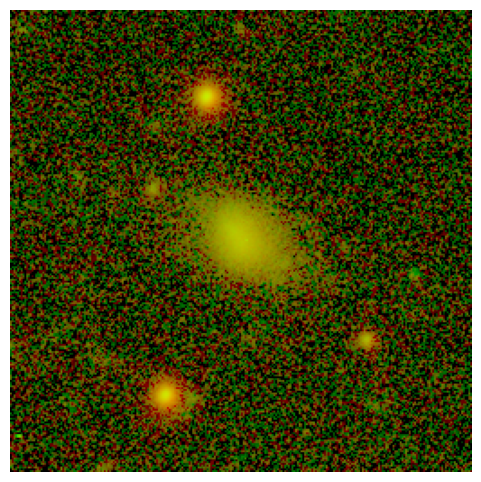

In [120]:
cutout_rgb = plot_cutout(cutout)
cutout_model = torch.tensor(cutout_rgb)
cutout_model = cutout_model.unsqueeze(0)

In [121]:
test_output_no_synth = model(cutout_model)

In [122]:
np.array_equal(test_output_synth, test_output_no_synth)

False

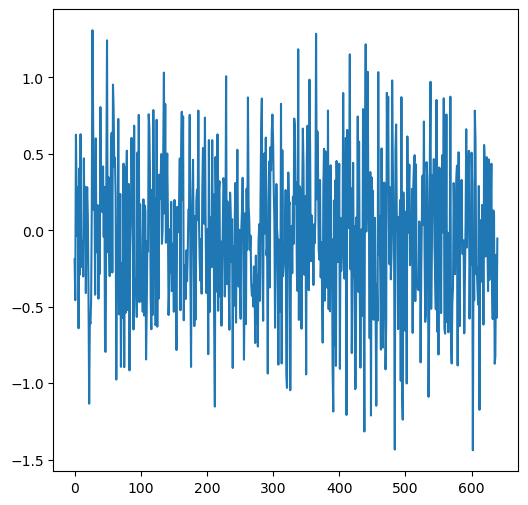

In [123]:
plt.figure(figsize=(6,6))
x = np.arange(test_output.shape[1])
plt.plot(x, test_output_synth.flatten())
plt.show()

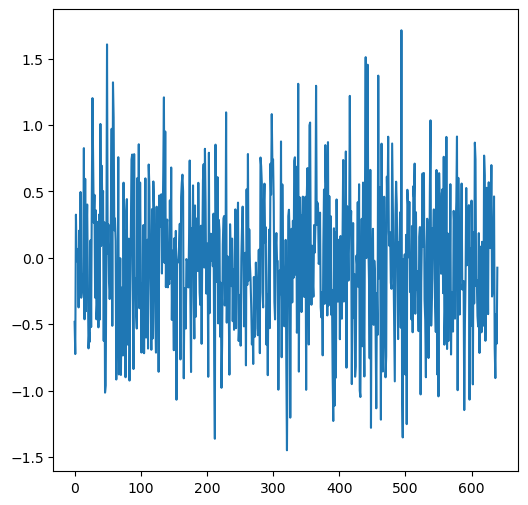

In [124]:
plt.figure(figsize=(6,6))
x = np.arange(test_output.shape[1])
plt.plot(x, test_output_no_synth.flatten())
plt.show()

In [82]:
test_output.shape[1]

640